In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from tqdm import tqdm

import flowtrain as ft

A collection of learning and generation solution making use of the StochasticInterpolator class and MLP for learning.

## Define Numerical Distributions

The goal is to define some simpler numerical distributions that have the same dataset and dataloader structure for sampling as a more complex dataset. This will allow the code to be interchangeable between the simpler and more complex datasets.

In [2]:
from flowtrain.dataloaders import Gaussian2d, GaussianMixed

# Prob distrcibutions X0 X1
mean = torch.Tensor([0.,0.])
eigenvals = torch.Tensor([2., 0.2])
axis =torch.Tensor([1.,1.])   

dsize = 8192
X0 = Gaussian2d(mean, eigenvals, axis, dsize, device='cpu')
X1 = GaussianMixed(size=dsize, device='cpu')
Z  = Gaussian2d(torch.Tensor([0.,0.]), torch.Tensor([1.,1.]), torch.Tensor([0.,1.]) ,dsize, device='cpu')
X0_loader = torch.utils.data.DataLoader(X0, batch_size=512, shuffle=True)
X1_loader = torch.utils.data.DataLoader(X1, batch_size=512, shuffle=True)
Z_loader  = torch.utils.data.DataLoader(Z, batch_size=512, shuffle=True)

A test plot of the two distributions to make sure that they are correct. A sampling method has been added to each to make it easier to draw samples. This scheme has been verified against a previous simpler numpy based implementation.

In [3]:
samples0 = X0.sample(500)
samples1 = X1.sample(500)

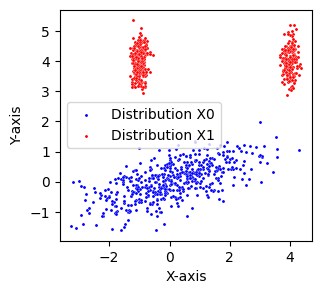

In [4]:
plt.figure(figsize=(5,3))
sns.scatterplot(x=samples0[:, 0], y=samples0[:, 1], color='blue', s=5, label='Distribution X0')
sns.scatterplot(x=samples1[:, 0], y=samples1[:, 1], color='red', s=5, label='Distribution X1')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

The general case for a field will take in a $x \in \mathbb{R}^n$ along with a time $t$ and output a vector in $\mathbb{R}^n$. The model can be a trained Unet or for a simpler case the MLP model can be used.

This is modified from https://github.com/atong01/conditional-flow-matching/tree/main

In [5]:
class MLP(torch.nn.Module):
    def __init__(self, dim, out_dim=None, w=64, hidden_layers=2):
        super().__init__()

        if out_dim is None:
            out_dim = dim

        # Initialize first layer + time dim
        init_layer = torch.nn.Sequential(
            torch.nn.Linear(dim + 1, w),
            torch.nn.SELU()
        )
        
        # Stack intermediate layers of even width for depth > 1
        inner_layer = torch.nn.Sequential(
            torch.nn.Linear(w, w),
            torch.nn.SELU()
        )

        # Initialize last layer
        last_layer = torch.nn.Linear(w, out_dim)
        
        self.net = torch.nn.Sequential(init_layer, *[inner_layer for _ in range(hidden_layers)], last_layer)

    def forward(self, x, t):
        # Concatenate x and t for the input
        xt = torch.cat([x, t[:, None]], dim=1)
        return self.net(xt)

In [6]:
dim = 2 # Here Rn is dimension 2
hidden_layers = 4
model = MLP(dim = dim, out_dim = 2, w = 128, hidden_layers=4)

## Training a simple model

An interpolator takes an interpolant of the form $x(t) = \alpha(t) x_0 + \beta(t) x_1 + \gamma(t) z$. All the interpolants of this class described in Albergo, Michael S., Nicholas M. Boffi, and Eric Vanden-Eijnden. “Stochastic Interpolants: A Unifying Framework for Flows and Diffusions.” arXiv, November 6, 2023. http://arxiv.org/abs/2303.08797. Page 27 have been implemented in the models.interpolants.

An interpolator can be used to generate reference objectives for training the model.


In [7]:
from flowtrain.interpolation import LinearInterpolant, StochasticInterpolator

interpolant = LinearInterpolant(one_sided = False, gamma_a=1.)
interp = StochasticInterpolator(interpolant)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
lossfn = torch.nn.MSELoss()

n_epochs = 100
batch_size = 512

# Loaders for each data type
X0_loader = torch.utils.data.DataLoader(X0, batch_size=batch_size)
X1_loader = torch.utils.data.DataLoader(X1, batch_size=batch_size)
Z_loader  = torch.utils.data.DataLoader(Z, batch_size=batch_size)

Learning the velocity flow objective
![](https://i.imgur.com/E9ovWkh.png)

#### Explore antithetic sampling 
For improved control over variance on b and s losses the sampling near $t=0$ and $t=1$ can be better controlled by using antithetic sampling. This is implemented as an option to return samples that have the $Z$ value mirrored to give sampling at $T,X0,X1,Z$ and $T,X0,X1,-Z$. The complementary sampling of $Z$ stabilizes the variance at the end points.

This is mostly important to consider in the cases of sampling $b$ and $s$

This could be added as a flag to a trainer

In [8]:
tqdm_epochs = tqdm(range(n_epochs))
for epoch in tqdm_epochs:
    loss_net = 0
    for i, (x0,x1,z) in enumerate(zip(X0_loader, X1_loader, Z_loader)):
        
        optimizer.zero_grad()        
        t = torch.rand(x0.shape[0])
        
        # Get truth from iterpolator
        xt_p, bt_p = interp.flow_objective(t, x0, x1, z)
        xt_m, bt_m = interp.flow_objective(t, x0, x1, -z)
        
        # Predict value
        b_hat_p = model(xt_p, t)
        b_hat_m = model(xt_m, t)

        # Loss on error
        loss = lossfn(b_hat_p, bt_p) + lossfn(b_hat_m, bt_m)
        
        loss.backward()    
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=90.0)
        optimizer.step()
        
        loss_net += loss.item()    
    
    tqdm_epochs.set_postfix({'epoch loss': loss_net/len(X0_loader)})

100%|██████████| 100/100 [00:40<00:00,  2.45it/s, epoch loss=13]    


### Solving the ODE for generation

A wrapper for the torchdiffeq library for solving ODE based flows requires a model that takes $x_t,t$ as parameters and can return the objective. This object handles ODE integration using a generic $f(x,t)$ function/model that can be passed in.

In [9]:
from flowtrain.solvers import ODEFlowSolver

solver = ODEFlowSolver(model)

y0 = X0.sample(500)
solution = solver.solve(y0, t0=.01, tf=1., n_steps=512);

A helper to plot trajectories is in the utils file.

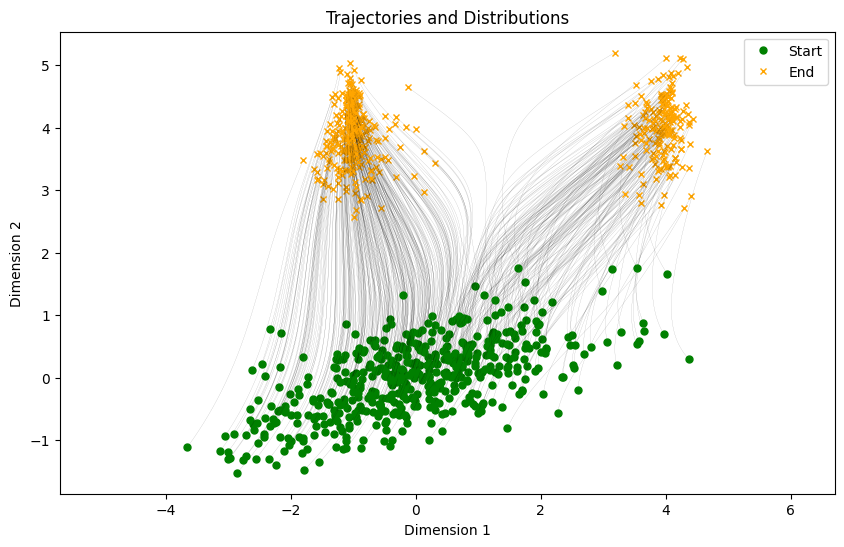

In [10]:
import flowtrain.utils as utils
utils.plot_trajectories(solution)

## Train on Denoiser, One-Sided Flow

Note that the interpolator library is set to retrieve the correct xt for both one-sided and two-sided interpolations. In the one-sided case x0 is the gaussian and x1 is the target distribution with no z, yes a little confusing, oh well.

In [11]:
from flowtrain.interpolation import LinearInterpolant, StochasticInterpolator

dim = 2 # Here Rn is dimension 2
model = MLP(dim = dim, out_dim = 2, w = 128)

interpolant = LinearInterpolant(one_sided = True, gamma_a=1.)
interp = StochasticInterpolator(interpolant)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
lossfn = torch.nn.MSELoss()

n_epochs = 200
batch_size = 512

# Loaders for each data type
X0_loader = torch.utils.data.DataLoader(X0, batch_size=batch_size)
X1_loader = torch.utils.data.DataLoader(X1, batch_size=batch_size)
Z_loader  = torch.utils.data.DataLoader(Z, batch_size=batch_size)

Note that $X_0$ is now the $Z$ loader since we are sampling $\rho_0$ from a Gaussian distribution

In [12]:
tqdm_epochs = tqdm(range(n_epochs))
for epoch in tqdm_epochs:
    loss_net = 0
    for i, (x0,x1) in enumerate(zip(Z_loader, X1_loader)):
        
        optimizer.zero_grad()        
        t = torch.rand(x0.shape[0])
        
        # Get truth from iterpolator
        xt, z = interp.denoising_objective(t, x0, x1)
        
        # Predict value
        eta = model(xt,t)
        # Loss on error
        loss = lossfn(eta, z)
        loss.backward()    
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=6.0)
        optimizer.step()
        
        loss_net += loss.item()    
    
    tqdm_epochs.set_postfix({'epoch loss': loss_net/len(X0_loader)})
    
denoising_model = model

100%|██████████| 200/200 [00:58<00:00,  3.43it/s, epoch loss=0.331]


### Solutions via ODE with denoising objective

In this case the solver to use is the one-sided denoising ODE which can generate samples from only a denoiser.

In [13]:
from flowtrain.solvers import ODEOneSidedDenoisingSolver

y0 = Z.sample(500)
print(y0.shape)

solver = ODEOneSidedDenoisingSolver(denoising_model, interpolant)
solution = solver.solve(y0, t0=.01, tf=.999, n_steps=512)

torch.Size([500, 2])


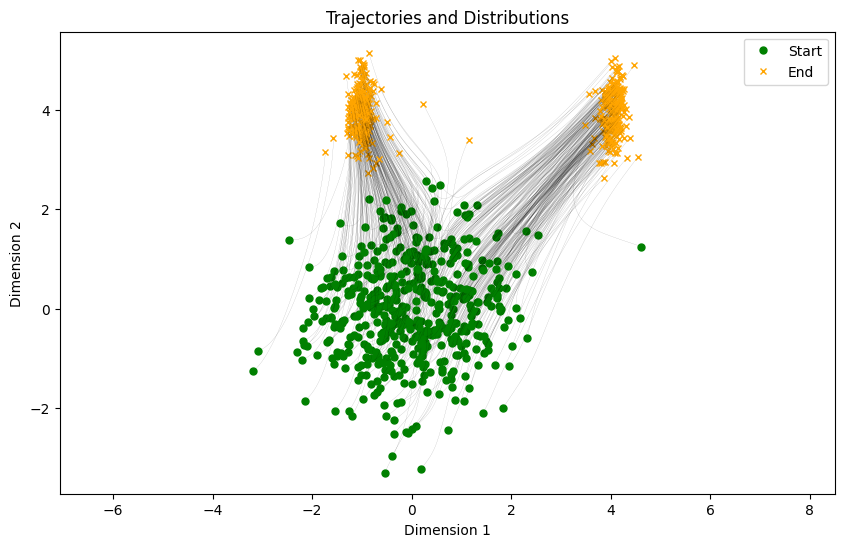

In [14]:
import stochinterp.utils as utils
utils.plot_trajectories(solution)